In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.comparison_tools import dataset_smart_read, dataset_light_read, distrib_score, spectral_score
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.computational_tools import PDF_histogram
from pyqg_generative.tools.simulate import run_simulation
%load_ext autoreload
%autoreload 3

import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

import warnings
warnings.filterwarnings("ignore")

# Determining enstrophy flux

In [201]:
ds = {}
ds['64_op1'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/*.nc', concat_dim='run', combine='nested', decode_times=False)
ds['64_op2'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-64/*.nc', concat_dim='run', combine='nested', decode_times=False)

ds['96_op1'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-96/*.nc', concat_dim='run', combine='nested', decode_times=False)
ds['96_op2'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-96/*.nc', concat_dim='run', combine='nested', decode_times=False)


In [356]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_512/[0-9].nc', concat_dim='run', combine='nested', decode_times=False)

In [357]:
vrms = velocity_rms(dss).compute()

In [202]:
def enstrophy_flux(ds):
    return -(ds.q_forcing_advection * ds.q).mean(['x','y', 'run'])

In [203]:
def velocity_rms(ds):
    return np.sqrt((ds.u**2 + ds.v**2).mean(['x', 'y', 'run']))

<xarray.DataArray ()>
array(0.07452768, dtype=float32)
Coordinates:
    lev      int64 1

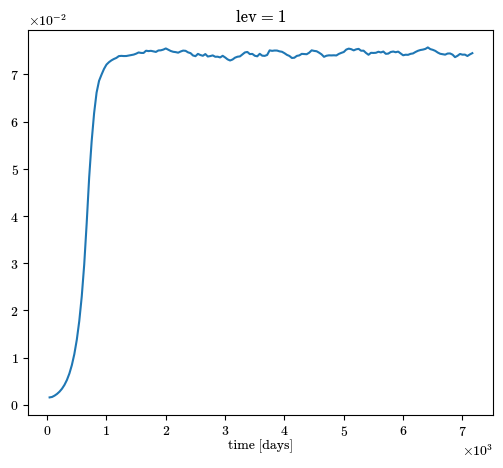

In [361]:
vrms.isel(lev=0).plot()
vrms.isel(lev=0).sel(time=slice(3600,None)).mean()

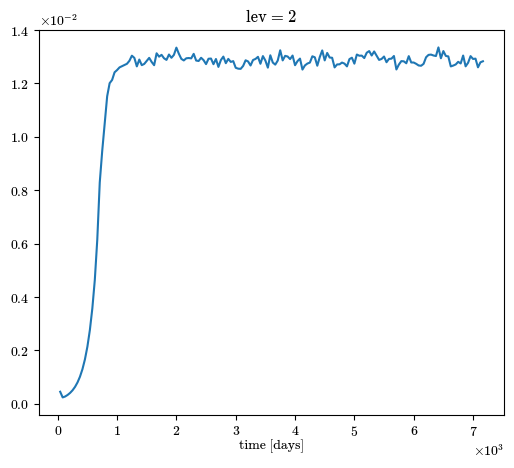

In [359]:
vrms.isel(lev=1).plot()

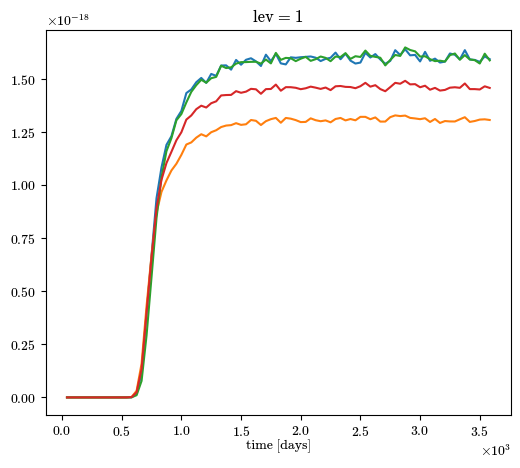

In [206]:
enstrophy_flux(ds['64_op1']).isel(lev=0).plot(label='64 op1')
enstrophy_flux(ds['64_op2']).isel(lev=0).plot(label='64 op2')

enstrophy_flux(ds['96_op1']).isel(lev=0).plot(label='96 op1')
enstrophy_flux(ds['96_op2']).isel(lev=0).plot(label='96 op2')

In [362]:
eta = enstrophy_flux(ds['64_op1']).isel(lev=0).compute()

In [367]:
eta.sel(time=slice(1800,None)).mean()

<xarray.DataArray ()>
array(1.5973519e-18, dtype=float32)
Coordinates:
    lev      int32 1

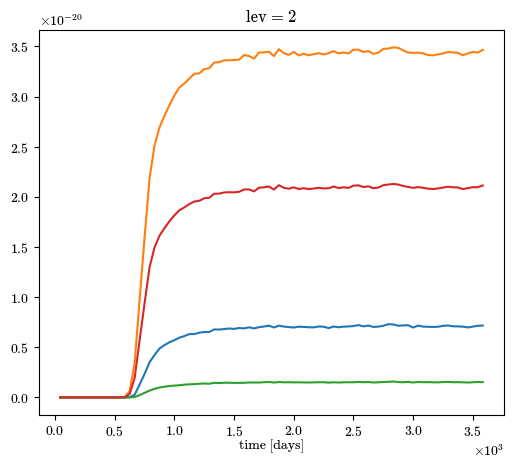

In [207]:
enstrophy_flux(ds['64_op1']).isel(lev=1).plot(label='64 op1')
enstrophy_flux(ds['64_op2']).isel(lev=1).plot(label='64 op2')

enstrophy_flux(ds['96_op1']).isel(lev=1).plot(label='96 op1')
enstrophy_flux(ds['96_op2']).isel(lev=1).plot(label='96 op2')

## All scales of motion
Domain length:
$$
L = 10^{6} m
$$

Velocity scale in upper layer:
$$
v_{rms}=0.07452768 m/s \approx 0.075 m/s
$$

Potential enstrophy flux over enstrophy cascade in upper layer:
$$
\eta = 1.5973519 \cdot 10^{-18} s^{-3} \approx 1.6 \cdot 10^{-18} s^{-3}
$$

## Kolmogorov scale
Dissipation (Kolmogorov) scale as a function of enstrophy flux and viscosity:
$$
l_{K} = \eta^{n} (\nu)^{k} = [1/T^3]^{n} [L^2/T]^{k} = L \rightarrow k=1/2, n=-1/2
$$
and
$$
l_{K} = {\nu}^{1/2} \eta^{-1/6}
$$

Typical choice: Kolmogorov lengthscale is equal to the grid step: 
$$
l_{K} \approx \Delta x
$$
See for explanation: https://journals.aps.org/prfluids/pdf/10.1103/PhysRevFluids.5.054606 (TABLE 1) also (Guan2022) https://www.sciencedirect.com/science/article/pii/S0021999122001528

Consequently, 
$$
\nu = \eta^{1/3} (\Delta x)^2
$$

Conversely, in diagnostic sense. The ratio of Kolmogorov scale to the grid scale:
$$
\frac{l_{K}}{\Delta x} = \frac{{\nu}^{1/2} \eta^{-1/6}}{\Delta x}
$$

## Reynolds number
In many works the length scale is chosen as
$$\tilde{L} = \frac{L}{2 \pi}$$
velocity scale as $v_{rms}$, and then the Reynolds number:
$$
Re = \frac{u_{rms} \tilde{L}}{\nu}
$$
Typical values for $Re$ is 64000 on a grid $1024^2$ (see Frezat, Guan, Kaushik). According to quadratic law we will scale Reynolds number for coarser grids.

In [376]:
for n in [48, 64, 96, 128, 256, 512, 1024, 2048]:
    L = 1e+6
    eta = 1.6e-18
    vrms = 0.075
    dx = L / float(n)
    
    L_tilde = L / (2 * np.pi)
    
    Re = 64000 * (n/1024)**2
    
    nu = vrms * L_tilde / Re
    
    Kolmogorov = nu**(0.5) * eta**(-1/6.)
    
    Re_compute = vrms * L_tilde / nu
    print(f'Resolution: {n}; viscosity (m^2/s): {nu}; Re: {Re,Re_compute}, Kolmogorov/dx: {Kolmogorov/dx}')

Resolution: 48; viscosity (m^2/s): 84.88263631567752; Re: (140.625, 140.625), Kolmogorov/dx: 0.40891276683620686
Resolution: 64; viscosity (m^2/s): 47.7464829275686; Re: (250.0, 250.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 96; viscosity (m^2/s): 21.22065907891938; Re: (562.5, 562.5), Kolmogorov/dx: 0.40891276683620686
Resolution: 128; viscosity (m^2/s): 11.93662073189215; Re: (1000.0, 1000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 256; viscosity (m^2/s): 2.9841551829730375; Re: (4000.0, 4000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 512; viscosity (m^2/s): 0.7460387957432594; Re: (16000.0, 16000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 1024; viscosity (m^2/s): 0.18650969893581484; Re: (64000.0, 64000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 2048; viscosity (m^2/s): 0.04662742473395371; Re: (256000.0, 256000.0), Kolmogorov/dx: 0.4089127668362069


# Pyqg with molecular viscosity

In [212]:
from pyqg import QParameterization

In [377]:
class Laplace(QParameterization):
    def __init__(self, nu=0., PV=True):
        self.nu = nu
        self.PV = PV

    def __call__(self, m):
        lap = m.ik**2 + m.il**2
        if self.PV:
            qh = m.qh
        else:
            qh = lap * m.ph
        
        dq = self.nu * m.ifft(lap * qh)
        return dq

In [378]:
pyqg_exp = {'nx': 64, 'dt': 14400, 'tmax': 311040000, 'tavestart': 155520000}
pyqg_lap = {'nx': 64, 'dt': 14400, 'tmax': 311040000, 'tavestart': 155520000, 'parameterization': Laplace(50,False), 'filterfac': 1e+20}
pyqg_invisc = {'nx': 64, 'dt': 14400, 'tmax': 311040000, 'tavestart': 155520000, 'filterfac': 1e+20}

In [307]:
invisc = run_simulation(pyqg_invisc)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 7.50e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 3.65e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 2.47e-05, CFL: 0.034
INFO: Step: 4000, Time years:  1.9, KE: 1.91e-04, CFL: 0.096
INFO: Step: 5000, Time years:  2.3, KE: 5.35e-04, CFL: 0.212
INFO: Step: 6000, Time years:  2.8, KE: 6.67e-04, CFL: 0.221
INFO: Step: 7000, Time years:  3.2, KE: 6.72e-04, CFL: 0.216
INFO: Step: 8000, Time years:  3.7, KE: 6.27e-04, CFL: 0.187
INFO: Step: 9000, Time years:  4.2, KE: 6.10e-04, CFL: 0.228
INFO: Step: 10000, Time years:  4.6, KE: 6.10e-04, CFL: 0.216
INFO: Step: 11000, Time years:  5.1, KE: 6.20e-04, CFL: 0.181
INFO: Step: 12000, Time years:  5.6, KE: 6.37e-04, CFL: 0.189
INFO: Step: 13000, Time years:  6.0, KE: 6.56e-04, CFL: 0.193
INFO: Step: 14000, Time years:  6.5, KE: 6.75e-04, CFL: 0.187
INFO: Step: 15000, Time years:  6.9, KE: 6.95e-04, CFL: 0.224
INFO: Step: 16000, Time years:  7.4, KE: 7.15e-04, CF

Function 'run_simulation' executed in 21.8433s


In [379]:
lap_50_rel = run_simulation(pyqg_lap)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 2.65e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 8.50e-07, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 3.14e-06, CFL: 0.023
INFO: Step: 4000, Time years:  1.9, KE: 1.19e-05, CFL: 0.023
INFO: Step: 5000, Time years:  2.3, KE: 4.58e-05, CFL: 0.029
INFO: Step: 6000, Time years:  2.8, KE: 1.76e-04, CFL: 0.055
INFO: Step: 7000, Time years:  3.2, KE: 6.91e-04, CFL: 0.118
INFO: Step: 8000, Time years:  3.7, KE: 3.70e-04, CFL: 0.146
INFO: Step: 9000, Time years:  4.2, KE: 2.27e-04, CFL: 0.131
INFO: Step: 10000, Time years:  4.6, KE: 1.71e-04, CFL: 0.108
INFO: Step: 11000, Time years:  5.1, KE: 1.37e-04, CFL: 0.107
INFO: Step: 12000, Time years:  5.6, KE: 1.54e-04, CFL: 0.103
INFO: Step: 13000, Time years:  6.0, KE: 1.57e-04, CFL: 0.115
INFO: Step: 14000, Time years:  6.5, KE: 1.75e-04, CFL: 0.134
INFO: Step: 15000, Time years:  6.9, KE: 1.63e-04, CFL: 0.127
INFO: Step: 16000, Time years:  7.4, KE: 1.91e-04, CF

Function 'run_simulation' executed in 25.3045s


In [309]:
exp = run_simulation(pyqg_exp)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 1.26e-06, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 7.87e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 5.99e-05, CFL: 0.038
INFO: Step: 4000, Time years:  1.9, KE: 4.56e-04, CFL: 0.137
INFO: Step: 5000, Time years:  2.3, KE: 4.78e-04, CFL: 0.212
INFO: Step: 6000, Time years:  2.8, KE: 5.23e-04, CFL: 0.222
INFO: Step: 7000, Time years:  3.2, KE: 4.92e-04, CFL: 0.163
INFO: Step: 8000, Time years:  3.7, KE: 4.77e-04, CFL: 0.206
INFO: Step: 9000, Time years:  4.2, KE: 4.49e-04, CFL: 0.160
INFO: Step: 10000, Time years:  4.6, KE: 4.79e-04, CFL: 0.206
INFO: Step: 11000, Time years:  5.1, KE: 4.84e-04, CFL: 0.177
INFO: Step: 12000, Time years:  5.6, KE: 4.59e-04, CFL: 0.156
INFO: Step: 13000, Time years:  6.0, KE: 4.88e-04, CFL: 0.177
INFO: Step: 14000, Time years:  6.5, KE: 5.15e-04, CFL: 0.194
INFO: Step: 15000, Time years:  6.9, KE: 4.91e-04, CFL: 0.166
INFO: Step: 16000, Time years:  7.4, KE: 5.26e-04, CF

Function 'run_simulation' executed in 22.0348s


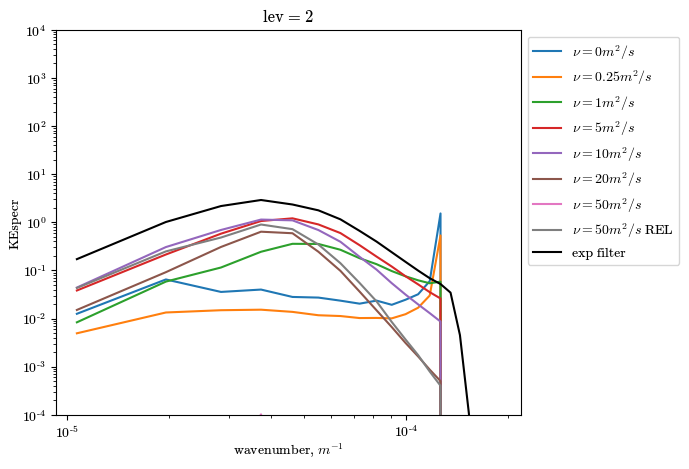

In [389]:
lev=1
dataset_light_read(invisc).KEspecr.isel(lev=lev).plot(label='$\\nu=0 m^2/s$')
dataset_light_read(lap_025).KEspecr.isel(lev=lev).plot(label='$\\nu=0.25 m^2/s$')
dataset_light_read(lap_1).KEspecr.isel(lev=lev).plot(label='$\\nu=1 m^2/s$')
dataset_light_read(lap_5).KEspecr.isel(lev=lev).plot(label='$\\nu=5 m^2/s$')
dataset_light_read(lap).KEspecr.isel(lev=lev).plot(label='$\\nu=10 m^2/s$')
dataset_light_read(lap_20).KEspecr.isel(lev=lev).plot(label='$\\nu=20 m^2/s$')
dataset_light_read(lap_50).KEspecr.isel(lev=lev).plot(label='$\\nu=50 m^2/s$')
dataset_light_read(lap_50_rel).KEspecr.isel(lev=lev).plot(label='$\\nu=50 m^2/s$ REL')
dataset_light_read(exp).KEspecr.isel(lev=lev).plot(color='k', label='exp filter')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-4,1e+4])
plt.legend(bbox_to_anchor=(1,1))